# Pytracking Final Project (PSC290_005)
## Dylan Antiovich, Xinger Yu, Alea Skwara

### This set of functions is designed to load, subset, visualize, and do basic analysis on AOI-based eye-tracking data. These functions do NOT employ fixation/saccade filters or classifications: any sample containing valid eye positions is taken into account.

# Function library

## Read in the data

In [1]:
def readFile(file):
    filetype = file[-3:]
    if filetype == 'csv':
        data = pd.read_csv(file)
    elif filetype == 'txt':
        data = pd.read_table(file)
    else:
        raise Exception("Error: unsupported file type, please convert to .csv or .txt")
    return data

## Classify the timepoints as inside or outside an AOI

In [2]:
# Return the AOI's name, size, and position
def __init__(data,AOI):
    stimName = imageType
    mediaW = abs(AOI[2] - AOI[0])
    mediaH = abs(AOI[3] - AOI[1])

    size = [mediaW, mediaH]
    position = [AOI[0], AOI[1]]
    return stimName, size, position

In [4]:
# Clean data set: remove null positions 
# Borrow from Alea's Create Eyetarcking Heatmap code 

def cleanData(data, stimCol, stimName, xCoord, yCoord):
    # Subset the dataframe for only the specified stimulus
    cleaned = data.ix[data[stimCol] == stimName]
        
    # Remove nulls from columns of interest (leaving only instances with x and y coordinates)
    cleaned = cleaned[cleaned[xCoordCol].notnull()]
    cleaned = cleaned[cleaned[yCoordCol].notnull()]
    
    x = cleaned[xCoordCol]
    y = cleaned[yCoordCol]
    
    position = (x, y)
    
    return position

In [5]:
# A class to check if the eye position falls into AOI 
class AOI:
    def init(self,aoitype,position,size):
    # AOItype = 'rectangle', 'circle'
    # pos = (x,y) position
    # size = [width height] list 
    
    # Check the format of AOI type and eye position 
        if aoitype not in ['rectangle','circle']:
            raise Exception("Error: aoitype is not recognized.")
        else:
            self.aoitype = aoitype
    
        if type(position) not in [tuple, list]:
            raise Exception("Error: AOI position should be an tuple or list")
        else:
            self.position = position
    
    # check the AOI size
        if type(size) == tuple:
            size = [size[0],size[1]]
        elif type(size) == list:
            pass
        else:
            raise Exception("Error: AOI size should be a list of integer values")    
        self.size = [int(size[0]),int(size[1])]

    # Check if the eye position falls into AOI     
    def contains(self, position):
        inside = 0; 
        if self.aoitype == 'circle':
            if (self.position[0]-position[0])**2 + (self.position[1]-position[1])**2 < self.r**2:
                inside = 1;
        elif self.aoitype == 'rectangle':
            if (position[0] > self.position[0] and position[0] < self.position[0]+self.size[0]) and (position[1] > self.position[1] and position[1] < self.position[1]+self.size[1]):
                inside = 1;
        else:
            raise Exception("Error: aoitype is not recognized.")   
        return inside

## Calculate gaze time for AOIs

In [6]:
# Calculate master dataframe 

def GazeData(AOIOneCoor, AOITwoCoor, xcoor, ycoor, subs, time, stim):
    
    import numpy as np
    import pandas as pd

    
    #the AOI variables expect a list of length 4: xmin, ymin, xmax, ymax
    AOIOneXmin = AOIOneCoor[0] 
    AOIOneYmin = AOIOneCoor[1] 
    AOIOneXmax = AOIOneCoor[2] 
    AOIOneYmax = AOIOneCoor[3]

    AOITwoXmin = AOITwoCoor[0] 
    AOITwoYmin = AOITwoCoor[1]  
    AOITwoXmax = AOITwoCoor[2]  
    AOITwoYmax = AOITwoCoor[3] 
    
    # create mask for AOI hits based on dimensions above
    AOIOne = (AOIOneXmin <= xcoor) & (xcoor <= AOIOneXmax) & (AOIOneYmin <= ycoor) & (ycoor <= AOIOneYmax)
    AOITwo = (AOITwoXmin <= xcoor) & (xcoor <= AOITwoXmax) & (AOITwoYmin <= ycoor) & (ycoor <= AOITwoYmax)

    trialNum = []
    trialList = []
    trialLen = []
    curstim = []
    subList = []
    gazedur1 = []
    gazedur2 = []
    for subID in set(subs):
        #get index of trial changes, based on change in stim name, 'MediaName' variable
        trials = np.roll(stim[subs == subID],1)!=stim[subs == subID] # onset of change in trial
        trialsOFF = np.roll(stim[subs == subID],-1)!=stim[subs == subID] # offset of change in trial
        trialLen.extend(np.subtract(time[subs == subID][trialsOFF], time[subs == subID][trials]))# build list of trial lengths for output dataframe
        trialNum.extend(trials.cumsum()) #get trial number by increasing trial number each time a new trial onset is found
        trialList.extend(np.unique(trialNum)) # build list of trials by subject for output dataframe
        subList.extend([subID]*len(trialList)) # build list of subjects for output dataframe

        for Trial in np.unique(trialNum):

            # Get onset/offset of gaze event changes for current subject and trial for AOIOne
            eventON1 = np.roll(AOIOne[subs == subID][trialNum == Trial],1) != AOIOne[subs == subID][trialNum == Trial]
            eventOFF1 = np.roll(AOIOne[subs == subID][trialNum == Trial],-1) != AOIOne[subs == subID][trialNum == Trial]

            # Get onset/offset of gaze event changes for current subject and trial for AOITwo
            eventON2 = np.roll(AOITwo[subs == subID][trialNum == Trial],1) != AOITwo[subs == subID][trialNum == Trial]
            eventOFF2 = np.roll(AOITwo[subs == subID][trialNum == Trial],-1) != AOITwo[subs == subID][trialNum == Trial]

            curstim.append(np.array(stim[subs == subID][trialNum == Trial])[0]) # build list of stimulus name for output dataframe

            # Get the difference between the gaze event onset and offset values in the timestamp, to get the total duration of gaze event, then sum up these events for the trial
            gazedur1.append(np.subtract(time[subs == subID][trialNum == Trial][AOIOne == True][eventOFF1], time[subs == subID][trialNum == Trial][AOIOne == True][eventON1]).sum())
            # Get the difference between the gaze event onset and offset values in the timestamp, to get the total duration of gaze event, then sum up these events for the trial
            gazedur2.append(np.subtract(time[subs == subID][trialNum == Trial][AOITwo == True][eventOFF2], time[subs == subID][trialNum == Trial][AOITwo == True][eventON2]).sum())
    
    # Build data frame from lists created in for loops
    outputDF = pd.DataFrame({'Subject': subList,
                             'Trial': trialList,
                             'TrialDuration_ms': trialLen,
                             'Stimulus': curstim,
                             'AOI_One_ms': gazedur1,
                             'AOI_Two_ms': gazedur2})
    outputDF = outputDF[['Subject','Trial', 'TrialDuration_ms','Stimulus', 'AOI_One_ms', 'AOI_Two_ms']]
    return(outputDF)

In [7]:
# Create group subsets from master dataframe

def GazeDataGroup (outputDF, kind):
    import pandas as pd
    
    if kind == 'stim':
        outputGROUP = outputDF.groupby(by = "Stimulus", as_index = False).mean() #get mean looking time to AOIs by stimulus name
       
    elif kind == 'sub':
        outputGROUP = outputDF.groupby(by = "Subject", as_index = False).mean() #get mean looking time to AOIs by subject ID

    elif kind == 'trial':
        outputGROUP = outputDF.groupby(by = "Trial", as_index = False).mean() #get mean looking time to AOIs by trial ID
    
    
    elif kind == 'long':   # get long format data for AOI, for stats function
        outputGROUP = pd.melt(frame = outputDF, id_vars = ['Subject', 'Trial', 'Stimulus'], value_vars = ['AOI_One_ms','AOI_Two_ms','TrialDuration_ms'] )
    
    return(outputGROUP)

In [8]:
# Export the gaze data as .csv

def ExportGazeData (filetitle, outputDF):
    outputDF.to_csv(filetitle + '.csv')

## Visualize the data

### Visualize the proportion of time looking toward AOIs

In [9]:
# Visualize proportion of looking toward AOIs
def PlotTrialProp(outputGROUP, kind):
    # plots proportion of looking toward AOI one vs. AOI two for by trial (kind 'trial') or by stimulus (kind 'stim')
    import matplotlib as plt
    import matplotlib.ticker as ticker
    if kind == 'stim':
        outputGROUP.AOI1propLook = (outputGROUP.AOI_One_ms/outputGROUP.TrialDuration_ms)
        outputGROUP.AOI2propLook = (outputGROUP.AOI_Two_ms/outputGROUP.TrialDuration_ms)
        ax = outputGROUP.AOI1propLook.plot(color='r', figsize=(30, 10), legend = True, label = 'AOI One')
        outputGROUP.AOI2propLook.plot(color='b', legend = True, label = 'AOI Two')
        tick_spacing = 1
        ax.set_xlabel('Stimulus', fontsize = 20)
        ax.set_ylabel('Proportion of looking to AOI', fontsize = 20)
        ax.tick_params(labelsize=10)
        ax.set_xticklabels(outputGROUP['Stimulus'], rotation=45)
        ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    elif kind == 'trial':
        outputGROUP.AOI1propLook = (outputGROUP.AOI_One_ms/outputGROUP.TrialDuration_ms)
        outputGROUP.AOI2propLook = (outputGROUP.AOI_Two_ms/outputGROUP.TrialDuration_ms)
        ax = outputGROUP.AOI1propLook.plot(color='r', figsize=(30, 10), legend = True, label = 'AOI One')
        outputGROUP.AOI2propLook.plot(color='b', legend = True, label = 'AOI Two')
        tick_spacing = 5
        ax.set_xlabel('Trial', fontsize = 20)
        ax.set_ylabel('Proportion of looking to AOI', fontsize = 20)
        ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
        ax.tick_params(labelsize=20)

### Create a heatmap

In [10]:
class heatmap():
    
    def __init__(self, data, kind = 'file'):
        self.data = self.load_data(file)
        self.subset = []
    
    def load_data(self, data, kind = 'file'):
        if kind == 'file':
            self.filetype = data[-3:]
            if self.filetype == 'csv':
                self.data = pd.read_csv(data)
            elif self.filetype == 'txt':
                self.data = pd.read_table(data)
            else:
                raise Exception("Error: unsupported file type, please convert to .csv or .txt")
        
        elif kind == 'pandasdataframe':
            self.data = data
        
        else:
            raise Exception("Error: please indicate data as file or pandasdataframe")
        
        return self.data
    
    def select_data(self, stimCol, stimName, xCoordCol, yCoordCol):
        # Subset the dataframe for only the specified stimulus
        self.subset = self.data.ix[self.data[stimCol] == stimName]
        
        # Remove nulls from columns of interest (leaving only instances with x and y coordinates)
        self.subset = self.subset[self.subset[xCoordCol].notnull()]
        self.subset = self.subset[self.subset[yCoordCol].notnull()]
        
        #return self.subset
    
    def draw_heatmap(self, stimWidth, stimHeight, xCoordCol, yCoordCol, xbins, ybins, title, 
                     origin = 'upper', transparent = 'no'):
        # pull the x and y coordinates
        x = self.subset[xCoordCol]
        y = self.subset[yCoordCol]

        # set the size of the plot to the dimensions of the stimulus
        heatmap, xedges, yedges = np.histogram2d(x, y, bins=(xbins,ybins))
        
        extent = [1, stimWidth, 1, stimHeight]
        
        if transparent == 'no':

            # Plot heatmap
            plt.clf()
            plt.title(title)
            plt.ylabel('y')
            plt.xlabel('x')
            plt.imshow(heatmap, extent=extent, origin = origin)
            plt.show()
        
        elif transparent == 'yes':
            img = np.zeros((xbins,ybins,4))
        
            img[:,:,0] = heatmap/heatmap.max()
            img[:,:,1] = np.zeros_like(heatmap)
            img[:,:,2] = np.zeros_like(heatmap)
            img[:,:,3] = heatmap/heatmap.max()
            
            plt.imshow(img, extent=extent, origin= origin)
            plt.show()
        
        
        else:
            raise Exception("Error: please specify superimpose as yes or no")

### Display look-patterns on the image

In [11]:
# Display one image type 
def display(size, imagefile=None):
    # construct a black background
    screen = np.zeros((size[1],size[0],3), dtype='uint8')
    if imagefile != None:
        # load image
        img = image.imread(imagefile)
        # flip image over the horizontal axis
        if not os.name == 'nt':
            img = np.flipud(img)
        width, height = len(img[0]), len(img)
        
        # start point 
        x = size[0]/2 - width/2
        y = size[1]/2 - height/2
        
        # Draw the image on the black background 
        screen[y:y+height,x:x+width,:] += img
        
    # Set the figure size in inches 
    dpi = 100.0
    figsize = (size[0]/dpi, size[1]/dpi)
    
    # create a figure
    fig = plt.figure(figsize=figsize, dpi=dpi, frameon=False)
    ax = plt.Axes(fig, [0,0,1,1])
    ax.set_axis_off()
    fig.add_axes(ax)
    
    # plot display
    ax.axis([0,size[0],0,size[1]])
    ax.imshow(screen, origin='upper')
      
    return fig, ax

## Statistics

### Run a permutation test on AOI fixation times

In [12]:
def permutation_test(data, indicator_variable, value_variable, label_1, label_2, n_permutation, hist = 'yes'):
    
    # Pull out the values and labels
    values1 = data[value_variable][data[indicator_variable]==label_1]
    values2 = data[value_variable][data[indicator_variable]==label_2]

    labels1 = data[indicator_variable][data[indicator_variable]==label_1]
    labels2 = data[indicator_variable][data[indicator_variable]==label_2]
    
    # Create a single list of values
    valueslist = values1.tolist() + values2.tolist()
    
    # Find the actual difference value
    truemean1 = np.mean(values1.tolist())
    truemean2 = np.mean(values2.tolist())
    
    truediff = truemean1 - truemean2
    
    # Create the data structure to store the permutation outcomes
    difflist = []
    
    # Create the null distribution by shuffling condition labels
    for n in range(n_permutation):
        
        # Concatenate the group labels into a single list
        labelslist = labels1.tolist() + labels2.tolist()
        
        # shuffle the label list
        shuffle(labelslist)
        
        # pull out the values that now randomly match to the shuffled labels
        outcome1 = [i for i,j in zip(valueslist,labelslist) if j == label_1]

        outcome2 = [i for i,j in zip(valueslist,labelslist) if j == label_2]

        
        # take the means of those shuffled conditions
        mean1 = np.mean(outcome1)

        mean2 = np.mean(outcome2)
        
        # subtract the means to get a difference
        diff = mean1 - mean2
        
        # store the value
        difflist.append(diff)
        
    
    # calculate a p-value of the actual difference
    pvalue = sum(abs(i) >= abs(truediff) for i in difflist)/n_permutation
    
    # print basic information about the data and outcome
    print('%s mean: %f\n%s mean: %f\ntrue difference: %f\n\npvalue = %f' 
          % (label_1, truemean1, label_2, truemean2, truediff, pvalue))
    
    if hist == 'yes':

        # make a histogram of the outcomes
        plt.hist(difflist)
        plt.plot([truediff, truediff], [0, n_permutation/10], 'k-', lw=2, color='red')
        plt.title('Outcome Distribution')
        plt.xlabel('Difference Between Condition Means')
        plt.ylabel('Frequency')
        
    elif hist == 'no':
        return
    else:
        raise Exception("Error: please specify hist as yes or no")
    
    # return the pvalue so that it can be used later (even though this isn't pretty)
    return(pvalue)

# Demonstration on data

## Packages these functions call

In [47]:
# Import the necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re 
import itertools
import random
import matplotlib as mpl

from matplotlib import image

from random import shuffle 



%matplotlib inline

In [48]:
# Set up variables that will be called

file = 'https://raw.githubusercontent.com/antovich/PyTrackingFinalProject/master/VSTM%20Data%20P18.txt'

stimCol = 'MediaName'

stimName = 'VSTM Green Yellow.jpg'

xCoordCol = 'GazePointX (MCSpx)'

yCoordCol = 'GazePointY (MCSpx)'

stimWidth = 1360

stimHeight = 768

origin = 'upper'

title = stimName

In [49]:
data = readFile(file)

### Check if timepoints fall into AOI regions

In [50]:

# Set the dimension for two AOIs manually
AOIOneXmin = 204 
AOIOneYmin = 208 
AOIOneXmax = 594 
AOIOneYmax = 561

AOITwoXmin = 777
AOITwoYmin = 208 
AOITwoXmax = 1167 
AOITwoYmax = 561

AOIone = [AOIOneXmin, AOIOneYmin, AOIOneXmax, AOIOneYmax]
AOItwo = [AOITwoXmin, AOITwoYmin, AOITwoXmax, AOITwoYmax]

# Check the number of different displays
imageType = data.MediaName.unique()
len(imageType)

# Return the dimensions and positions of the AOIs
AOIl = __init__(data,AOIone)
AOIr = __init__(data,AOItwo)

AOItype = 'rectangle'
DisplayList = AOIl[0]
AOIsize = AOIl[1]
AOILposition = AOIl[2]
AOIRposition = AOIr[2]

In [51]:
# Get eye positions for one type of display 

Position = cleanData(data, stimCol, DisplayList[2], xCoordCol, yCoordCol)

print(Position)

(57     816.0
58     810.0
59     811.0
60     812.0
61     814.0
62     812.0
63     812.0
64     818.0
65     814.0
66     812.0
67     808.0
68     811.0
69     809.0
70     811.0
71     806.0
72     809.0
73     807.0
74     809.0
75     782.0
76     639.0
77     511.0
78     512.0
79     502.0
80     512.0
81     505.0
82     499.0
83     507.0
84     513.0
85     514.0
86     516.0
       ...  
209    467.0
210    465.0
211    474.0
212    458.0
213    466.0
214    466.0
215    472.0
216    474.0
217    473.0
218    480.0
219    473.0
220    467.0
221    475.0
222    471.0
223    477.0
224    479.0
225    476.0
226    472.0
227    480.0
228    472.0
229    480.0
230    473.0
231    472.0
232    476.0
233    472.0
234    380.0
235    278.0
236    273.0
237    275.0
238    274.0
Name: GazePointX (MCSpx), dtype: float64, 57     405.0
58     405.0
59     410.0
60     411.0
61     410.0
62     408.0
63     406.0
64     411.0
65     406.0
66     411.0
67     414.0
68     407.0
69     4

In [52]:

# Check if the eye positions fall into the left AOI 
sub = AOI()
insideL = []
sub.init(AOItype,AOILposition,AOIsize)
for j in range (57, len(Position[0])+57):
    xCoord = Position[0][j]
    yCoord = Position[1][j]
    p = [xCoord, yCoord]
    if sub.contains(p) == 1:
        insideL.append(p)
        
# Check if the eye positions fall into the right AOI 
insideR = []
sub.init(AOItype,AOIRposition,AOIsize)
for j in range (57, len(Position[1])+57):
    xCoord = Position[0][j]
    yCoord = Position[1][j]
    p = [xCoord, yCoord]
    # Store the inside range eye positions into a list 
    if sub.contains(p) == 1:
        insideR.append(p)

In [53]:
# Get subject ID
subID = data.ParticipantName.unique()

# A data frame composde of subID, picture type, eye position, AOI type
Ntrial = len(Position[1])
AOIlist = ['Left']*len(insideL) + ['Right']*len(insideR) + ['NaN']*(Ntrial-len(insideL)-len(insideR))
df = pd.DataFrame({'Eye Position' : insideL + insideR + ['Outside']*(Ntrial-len(insideL)-len(insideR)), 
                   'AOI' : AOIlist,
                   'ImageName' : [DisplayList[2]] * Ntrial,
                   'subID' : [subID[0]] * Ntrial})

In [54]:
df

,AOI,Eye Position,ImageName,subID
0,Left,"[511.0, 450.0]",VSTM Red Yellow.jpg,P18
1,Left,"[512.0, 449.0]",VSTM Red Yellow.jpg,P18
2,Left,"[502.0, 452.0]",VSTM Red Yellow.jpg,P18
3,Left,"[512.0, 454.0]",VSTM Red Yellow.jpg,P18
4,Left,"[505.0, 453.0]",VSTM Red Yellow.jpg,P18
5,Left,"[499.0, 497.0]",VSTM Red Yellow.jpg,P18
6,Left,"[507.0, 459.0]",VSTM Red Yellow.jpg,P18
7,Left,"[513.0, 461.0]",VSTM Red Yellow.jpg,P18
8,Left,"[514.0, 458.0]",VSTM Red Yellow.jpg,P18
9,Left,"[516.0, 453.0]",VSTM Red Yellow.jpg,P18


### Calculate gaze time in AOIs

In [55]:
# Calculate gaze times and safe in master df
df = GazeData(AOIOneCoor = [204, 208, 594, 561], AOITwoCoor = [777, 208, 1167, 561], xcoor = data['GazePointX (MCSpx)'], ycoor = data['GazePointY (MCSpx)'], subs = data['ParticipantName'], time = data['RecordingTimestamp'], stim = data['MediaName']) 

# convert to long format
dfLONG = GazeDataGroup (df, 'long')

# group by stim
dfSTIM = GazeDataGroup (df, 'stim')


In [56]:
# Export gaze data
ExportGazeData ('Test File', df)

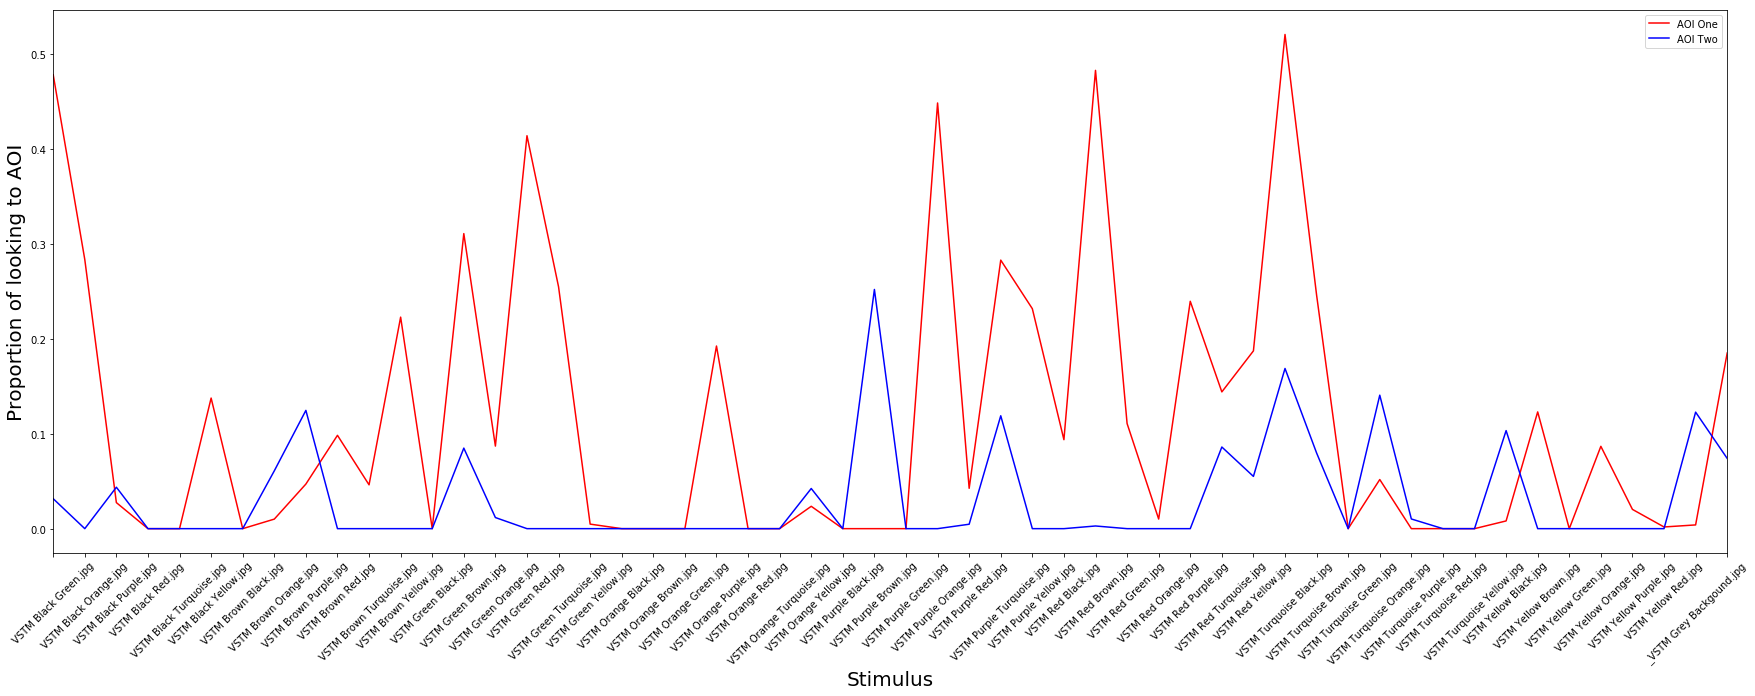

In [57]:
# Plot the proportion of gaze time for each AOI
PlotTrialProp(dfSTIM, 'stim')

### Draw a heatmap of gaze time

In [58]:
# Set up the heatmap

# set the parameters back to the default
mpl.rcParams.update(mpl.rcParamsDefault)

greenyellowheat = heatmap(file, kind = 'file')

greenyellowheat.select_data(stimCol, stimName, xCoordCol, yCoordCol)

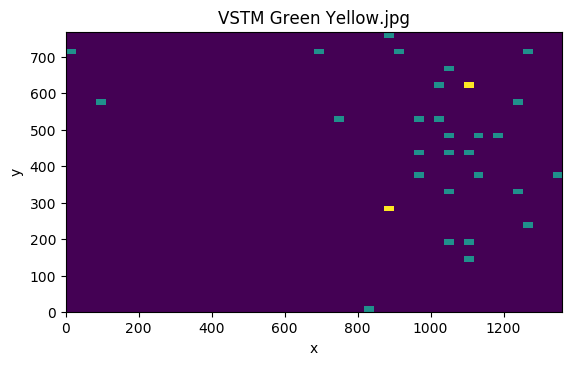

In [59]:
# Draw a heatmap

greenyellowheat.draw_heatmap(stimWidth, stimHeight, xCoordCol, yCoordCol, 
                             title = stimName, transparent = 'no', xbins=50, ybins=50)

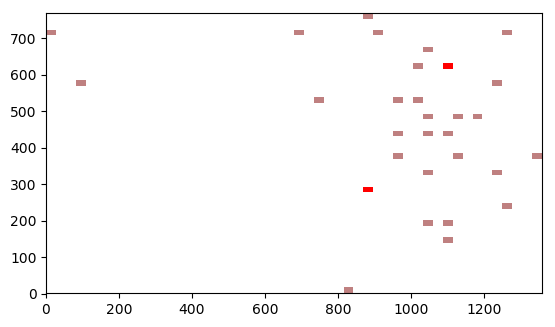

In [60]:
# Draw a transparent heatmap
greenyellowheat.draw_heatmap(stimWidth, stimHeight, xCoordCol, yCoordCol, 
                             title = stimName, transparent = 'yes', xbins=50, ybins=50)


### Visualize look points on the stim file

/Users/aleaskwara/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:18: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


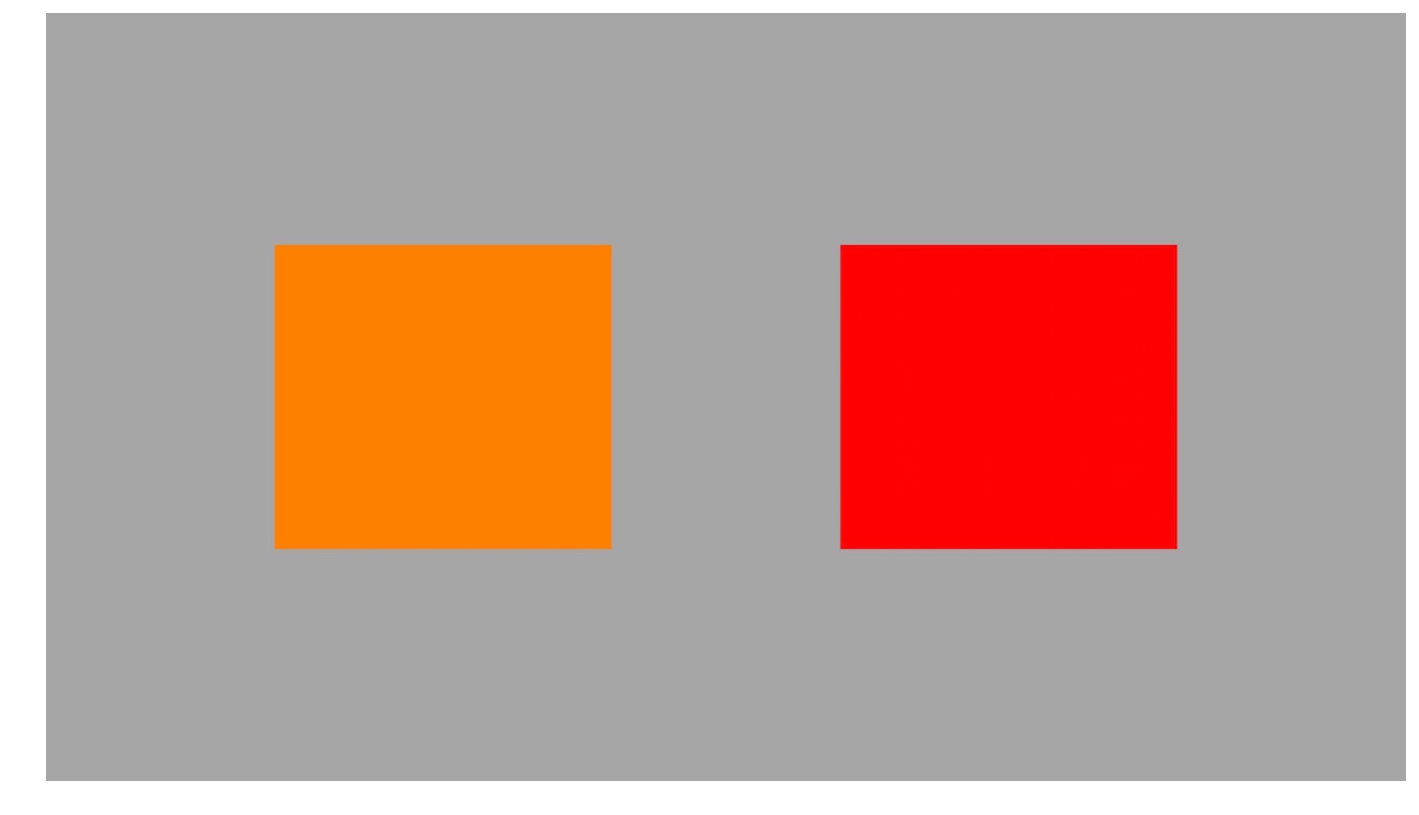

In [61]:
imagefile = '/Users/aleaskwara/Desktop/VSTM Orange Red.jpg'
# this needs to be set to a local file
size = (1360,768)
fig, ax = display(size, imagefile)

/Users/aleaskwara/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:18: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


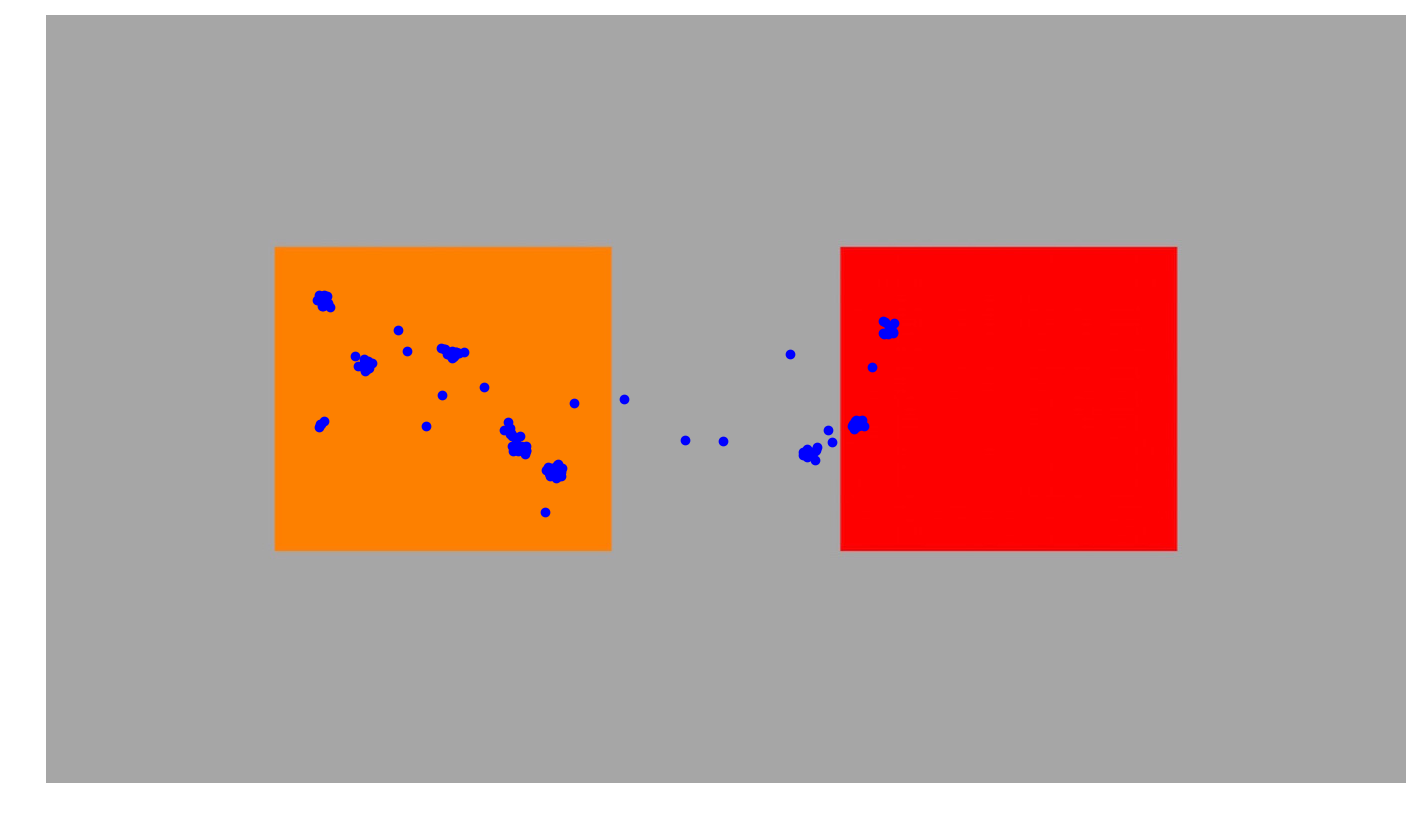

In [62]:
fig, ax = display(size, imagefile=imagefile)

# plot raw eye positions on the stimulus
plt.scatter(x = Position[0], y = Position[1], c='blue')
ax.invert_yaxis()

### Run a permutation test comparing AOIs 1 and 2

AOI_One_ms mean: 148.427083
AOI_Two_ms mean: 41.187500
true difference: 107.239583

pvalue = 0.000000


0.0

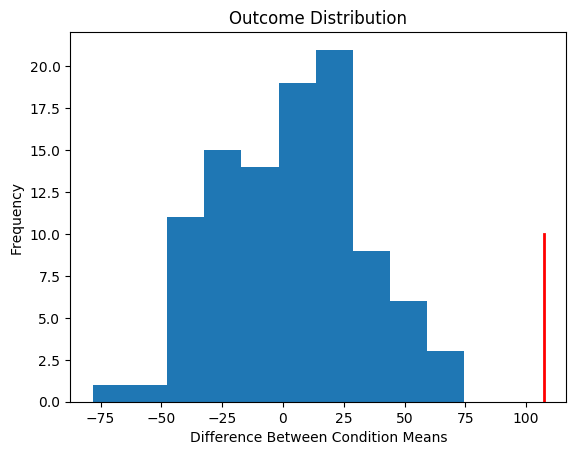

In [74]:
# Run a permutation test to compare gaze time for AOI1 vs AOI2
permutation_test(data=dfLONG, indicator_variable = 'variable', value_variable = 'value', 
                label_1 = 'AOI_One_ms', label_2 = 'AOI_Two_ms', n_permutation = 100, hist = 'yes')

## NOTE: this doesn't make sense as an actual test as it
## looks across all different stimuli presented. As file sizes are very
## large, we have been working with a single subject's file to build 
## example code, and therefore had to use all stimuli to have enough data
## to run a statistical test. Thus this is only meant to serve
## as an example of how the function works
